### Lab | Making predictions with logistic regression

In [ ]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import getpass 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score



In [2]:
password = getpass.getpass()

········


In [3]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

query_film = '''select film_id, title, rental_duration, rental_rate, length, rating, special_features from film;'''
query_may = '''select f.film_id, count(r.rental_id) as rent_may from rental as r
left join inventory as i
using (inventory_id)
left join film as f
using (film_id)
where left(r.rental_date,7) = '2005-05'
group by f.film_id;'''
query_jun = '''select f.film_id, count(r.rental_id) as rent_jun from rental as r
left join inventory as i
using (inventory_id)
left join film as f
using (film_id)
where left(r.rental_date,7) = '2005-06'
group by f.film_id;'''
query_jul = '''select f.film_id, count(r.rental_id) as rent_jul from rental as r
left join inventory as i
using (inventory_id)
left join film as f
using (film_id)
where left(r.rental_date,7) = '2005-07'
group by f.film_id;'''
data_rental = pd.read_sql('rental', engine)
data_inventory = pd.read_sql('inventory', engine)
data_film = pd.read_sql_query(query_film, engine)
data_film_cat = pd.read_sql('film_category', engine)
data_may = pd.read_sql_query(query_may, engine)
data_jun = pd.read_sql_query(query_jun, engine)
data_jul = pd.read_sql_query(query_jul, engine)


/Users/ttrofff/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:618: SAWarning: Did not recognize type 'geometry' of column 'location'
  pandas_sql.meta.reflect(only=[sql])
/Users/ttrofff/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:618: SAWarning: Did not recognize type 'geometry' of column 'location'
  pandas_sql.meta.reflect(only=[sql])


In [4]:
# film_id(all) rentals_may rentals_june rentals_june

step1 = pd.merge(left = data_film,
                                  right = data_may,
                                  how = 'left', 
                                  left_on = "film_id", 
                                  right_on = "film_id")
step2 = pd.merge(left = step1,
                                  right = data_jun,
                                  how = 'left', 
                                  left_on = "film_id", 
                                  right_on = "film_id")

step3 = pd.merge(left = step2,
                                  right = data_jul,
                                  how = 'left', 
                                  left_on = "film_id", 
                                  right_on = "film_id")


data = step3.copy()
data.head()

,film_id,title,rental_duration,rental_rate,length,rating,special_features,rent_may,rent_jun,rent_jul
0,1,ACADEMY DINOSAUR,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",2.0,3.0,9.0
1,2,ACE GOLDFINGER,3,4.99,48,G,"Trailers,Deleted Scenes",NaN,NaN,2.0
2,3,ADAPTATION HOLES,7,2.99,50,NC-17,"Trailers,Deleted Scenes",1.0,1.0,4.0
3,4,AFFAIR PREJUDICE,5,2.99,117,G,"Commentaries,Behind the Scenes",2.0,2.0,12.0
4,5,AFRICAN EGG,6,2.99,130,G,Deleted Scenes,1.0,2.0,5.0


In [5]:
data['film_id'] = data['film_id'].astype('object')
data.describe()

,rental_duration,rental_rate,length,rent_may,rent_jun,rent_jul
count,1000.000000,1000.000000,1000.000000,686.000000,900.000000,958.000000
mean,4.985000,2.980000,115.272000,1.685131,2.567778,7.003132
std,1.411654,1.646393,40.426332,0.852637,1.281713,2.933429
min,3.000000,0.990000,46.000000,1.000000,1.000000,1.000000
25%,4.000000,0.990000,80.000000,1.000000,2.000000,5.000000
50%,5.000000,2.990000,114.000000,1.000000,2.000000,7.000000
75%,6.000000,4.990000,149.250000,2.000000,3.000000,9.000000
max,7.000000,4.990000,185.000000,5.000000,7.000000,16.000000


In [6]:
# lets clear NaNs: NaN = zero rentals

data['rent_may'].fillna(0, inplace = True)
data['rent_jun'].fillna(0, inplace = True)
data['rent_jul'].fillna(0, inplace = True)
data.describe()

,rental_duration,rental_rate,length,rent_may,rent_jun,rent_jul
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.985000,2.980000,115.272000,1.156000,2.311000,6.709000
std,1.411654,1.646393,40.426332,1.053933,1.439566,3.196645
min,3.000000,0.990000,46.000000,0.000000,0.000000,0.000000
25%,4.000000,0.990000,80.000000,0.000000,1.000000,4.000000
50%,5.000000,2.990000,114.000000,1.000000,2.000000,7.000000
75%,6.000000,4.990000,149.250000,2.000000,3.000000,9.000000
max,7.000000,4.990000,185.000000,5.000000,7.000000,16.000000


In [7]:
# lets split special_features
# data['special_features'].unique()
# Deleted Scenes, Behind the Scenes, Trailers, Commentaries

def special_separation(x):
    y=[0,0,0,0]
    z=['Deleted Scenes', 'Behind the Scenes', 'Trailers', 'Commentaries']
    for i in y:
        for j in range(0,len(z)):
            if z[j] in x:
                y[j]=1
    y = [str(i) for i in y]
    y = ",".join(y)
    return y

data['special']=data['special_features'].apply(special_separation)
data[['sf_ds', 'sf_bs', 'sf_t','sf_c']]=data['special'].str.split(',', expand=True)
data = data.drop(['special', 'special_features'], axis=1)
data.head()

,film_id,title,rental_duration,rental_rate,length,rating,rent_may,rent_jun,rent_jul,sf_ds,sf_bs,sf_t,sf_c
0,1,ACADEMY DINOSAUR,6,0.99,86,PG,2.0,3.0,9.0,1,1,0,0
1,2,ACE GOLDFINGER,3,4.99,48,G,0.0,0.0,2.0,1,0,1,0
2,3,ADAPTATION HOLES,7,2.99,50,NC-17,1.0,1.0,4.0,1,0,1,0
3,4,AFFAIR PREJUDICE,5,2.99,117,G,2.0,2.0,12.0,0,1,0,1
4,5,AFRICAN EGG,6,2.99,130,G,1.0,2.0,5.0,1,0,0,0


In [8]:
# lets convert everything we can to integer

list = ['rent_may', 'rent_jun', 'rent_jul', 'sf_ds', 'sf_bs', 'sf_t', 'sf_c']
data[list] = data[list].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   film_id          1000 non-null   object 
 1   title            1000 non-null   object 
 2   rental_duration  1000 non-null   int64  
 3   rental_rate      1000 non-null   float64
 4   length           1000 non-null   int64  
 5   rating           1000 non-null   object 
 6   rent_may         1000 non-null   int64  
 7   rent_jun         1000 non-null   int64  
 8   rent_jul         1000 non-null   int64  
 9   sf_ds            1000 non-null   int64  
 10  sf_bs            1000 non-null   int64  
 11  sf_t             1000 non-null   int64  
 12  sf_c             1000 non-null   int64  
dtypes: float64(1), int64(9), object(3)
memory usage: 109.4+ KB


In [9]:
# now lets do the main column 

data['growth'] = data['rent_jul']>data['rent_jun']

def growth_format(x):
    if x == True:
        x = 'Yes'
    else: x = 'No'
    return x

data['growth'] = data['growth'].apply(growth_format)

data.head()
#data['rent_jul']>data['rent_jun']

,film_id,title,rental_duration,rental_rate,length,rating,rent_may,rent_jun,rent_jul,sf_ds,sf_bs,sf_t,sf_c,growth
0,1,ACADEMY DINOSAUR,6,0.99,86,PG,2,3,9,1,1,0,0,Yes
1,2,ACE GOLDFINGER,3,4.99,48,G,0,0,2,1,0,1,0,Yes
2,3,ADAPTATION HOLES,7,2.99,50,NC-17,1,1,4,1,0,1,0,Yes
3,4,AFFAIR PREJUDICE,5,2.99,117,G,2,2,12,0,1,0,1,Yes
4,5,AFRICAN EGG,6,2.99,130,G,1,2,5,1,0,0,0,Yes


In [10]:
# we have problems as the data is very biased towards growth (95% of observations)

data.growth.value_counts()

Yes    952
No      48
Name: growth, dtype: int64

### Regression analysis

In [11]:
# lets drop the title and film_id (useless), as well as rent_jul (this is a quasi-dependent variable)

data_reg=data.drop(['title','film_id','rent_jun'], axis=1)
data_reg.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rental_duration  1000 non-null   int64  
 1   rental_rate      1000 non-null   float64
 2   length           1000 non-null   int64  
 3   rating           1000 non-null   object 
 4   rent_may         1000 non-null   int64  
 5   rent_jul         1000 non-null   int64  
 6   sf_ds            1000 non-null   int64  
 7   sf_bs            1000 non-null   int64  
 8   sf_t             1000 non-null   int64  
 9   sf_c             1000 non-null   int64  
 10  growth           1000 non-null   object 
dtypes: float64(1), int64(8), object(2)
memory usage: 93.8+ KB


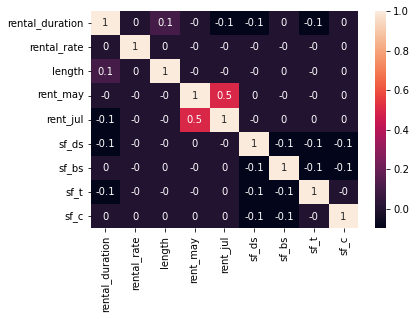

In [12]:
# look for corr matrix of numerical part
# no multicolinearity can be found

correlations_matrix = data_reg.corr().round(1)
sns.heatmap(correlations_matrix, annot=True)
plt.show()

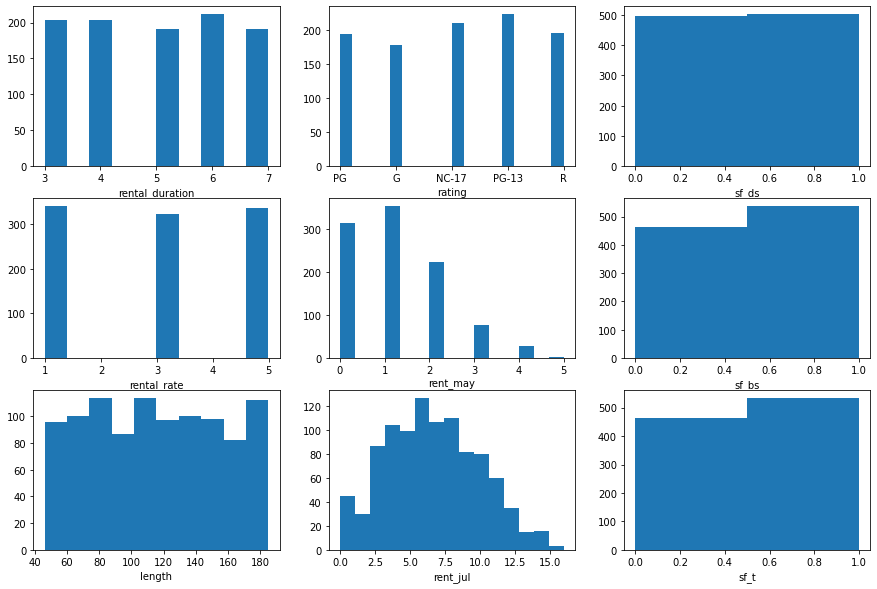

In [13]:
fig, axs = plt.subplots(3,3, figsize=(15, 10))

axs[0,0].hist(x='rental_duration',data=data, bins=10)
axs[0,0].set_xlabel('rental_duration')
axs[1,0].hist(x='rental_rate',data=data, bins=10)
axs[1,0].set_xlabel('rental_rate')
axs[2,0].hist(x='length',data=data, bins=10)
axs[2,0].set_xlabel('length')
axs[0,1].hist(x='rating',data=data, bins=18)
axs[0,1].set_xlabel('rating')
axs[1,1].hist(x='rent_may',data=data, bins=15)
axs[1,1].set_xlabel('rent_may')
axs[2,1].hist(x='rent_jul',data=data, bins=15)
axs[2,1].set_xlabel('rent_jul')
axs[0,2].hist(x='sf_ds',data=data, bins=2)
axs[0,2].set_xlabel('sf_ds')
axs[1,2].hist(x='sf_bs',data=data, bins=2)
axs[1,2].set_xlabel('sf_bs')
axs[2,2].hist(x='sf_t',data=data, bins=2)
axs[2,2].set_xlabel('sf_t')

plt.show()

In [14]:
# X-y split
y = data_reg['growth']
X = data_reg.drop(['growth'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31337)

In [15]:
X_train_num = X_train.select_dtypes([np.number])

from sklearn.preprocessing import MinMaxScaler

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) 
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized)

In [16]:
X_train_norm.columns = X_train_num.columns
X_train_norm.shape

(800, 9)

In [17]:
X_train_categorical = X_train.select_dtypes(include = np.object)
X_train_cat = pd.get_dummies(X_train_categorical, 
                             columns=['rating'],
                             drop_first=True)
X_train_cat.shape


/var/folders/40/fpzt8rqs1hd_nf7fht4s6n240000gn/T/ipykernel_31849/3242086671.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train_categorical = X_train.select_dtypes(include = np.object)


(800, 4)

In [18]:
#concatenating into one table

X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)


In [19]:
# running the regression

from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [20]:
# adjusting test portion

X_test_num = X_test.select_dtypes(include = np.number)

X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)

X_test_categorical = X_test.select_dtypes(include = np.object)
X_test_cat = pd.get_dummies(X_test_categorical, 
                            columns=['rating'],
                            drop_first=True)

X_test_cat.head()

/var/folders/40/fpzt8rqs1hd_nf7fht4s6n240000gn/T/ipykernel_31849/507503634.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test_categorical = X_test.select_dtypes(include = np.object)


,rating_NC-17,rating_PG,rating_PG-13,rating_R
81,0,0,0,0
353,0,0,0,0
361,0,0,1,0
657,0,0,1,0
944,0,0,0,1


In [21]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)

In [22]:
# lets make predictions
predictions_train = classification.predict(X_train_transformed)
predictions_test  = classification.predict(X_test_transformed)

The confusion matrix on the TRAIN set is: 


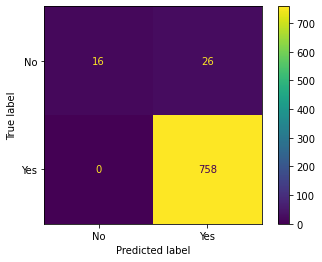

In [29]:
print("The confusion matrix on the TRAIN set is: ")
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, predictions_train)

disp = ConfusionMatrixDisplay(cm,display_labels=classification.classes_);
disp.plot()
plt.show()

The confusion matrix on the TEST set is: 


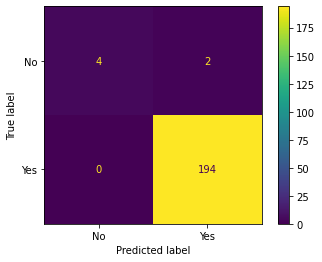

In [30]:
print("The confusion matrix on the TEST set is: ")
cm_test = confusion_matrix(y_test, predictions_test)
cm_test
disp = ConfusionMatrixDisplay(cm_test,display_labels=classification.classes_);
disp.plot()
plt.show()

In [35]:
print(classification_report(y_train, predictions_train,target_names=['no','yes']))

              precision    recall  f1-score   support

          no       1.00      0.38      0.55        42
         yes       0.97      1.00      0.98       758

    accuracy                           0.97       800
   macro avg       0.98      0.69      0.77       800
weighted avg       0.97      0.97      0.96       800



In [36]:
print(classification_report(y_test, predictions_test,target_names=['no','yes']))

              precision    recall  f1-score   support

          no       1.00      0.67      0.80         6
         yes       0.99      1.00      0.99       194

    accuracy                           0.99       200
   macro avg       0.99      0.83      0.90       200
weighted avg       0.99      0.99      0.99       200



In [ ]:
# the data is biased towards one outcome ('yes' in 95% of observations).
# we can see this in confusion matrices ans classification reports.
# despite very high accuracy and precission the model is as biased as the data. 
# interesting that the model for both datasets produced zero false negative resulsts.
# recall for 'no' observation is low as the result of the bias towards 'yes' outcome
# due to low number of 'no' observations measures of recall and f1-score vary significantly in test and train df.
# Kappa tells us that the agreement between the modelled and actual distribution is only moderate.

In [28]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_train, predictions_train)

0.5383522727272727